# BTF quad scan

In [1]:
import os
from os.path import join
from collections import Counter
from datetime import datetime
import h5py
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt
import proplot as pplt

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'

In [2]:
def get_quad_id(filename):
    return filename.split('_')[3]

def get_quad_number(filename):
    return int(get_quad_id(filename)[2:])
        
folder = 'Diagnostics/Data/Measurements/2022-04-14/'
filenames = os.listdir(folder)
filenames = [filename for filename in filenames if 'orbit_response' not in filename]
filenames = sorted(filenames, key=get_quad_number, reverse=True)
filenames

['220414120752-quad_scan-response_HZ34a_QV34_BS34.h5',
 '220414121120-quad_scan-response_HZ34a_QH33_BS34.h5',
 '220414121432-quad_scan-response_HZ34a_QH13_BS34.h5',
 '220414121744-quad_scan-response_HZ34a_QV12_BS34.h5',
 '220414122057-quad_scan-response_HZ34a_QH11_BS34.h5',
 '220414122409-quad_scan-response_HZ34a_QV10_BS34.h5',
 '220414122722-quad_scan-response_HZ34a_QV09_BS34.h5',
 '220414123034-quad_scan-response_HZ34a_QH08_BS34.h5',
 '220414123347-quad_scan-response_HZ34a_QV07_BS34.h5',
 '220414123700-quad_scan-response_HZ34a_QV06_BS34.h5',
 '220414124012-quad_scan-response_HZ34a_QH05_BS34.h5',
 '220414124325-quad_scan-response_HZ34a_QV04_BS34.h5',
 '220414124638-quad_scan-response_HZ34a_QH03_BS34.h5']

## Explore one file 

In [3]:
filename = filenames[0]
file = h5py.File(join(folder, filename), 'r')

In [4]:
list(file.keys())

['config', 'log', 'scandata']

In [5]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

environment
--------------
timestamp: [1.64995247e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'misc/quad_scan.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.64995248e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [5.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94000244]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.05999756]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.6500001]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.67000008]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.25]
BTF_MEBT_Mag:PS_QH08:I_Set: [3.72099996]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.60000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-2.]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.5]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.10000038]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.4]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.9]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.5]
BTF_MEBT_Mag:PS_DCV01:I_Set: [9.]
BTF_MEBT_Mag:PS_DCH02:I_Set: [5.]
BTF_MEBT_Mag:PS_DCV02:I_Set: [-9.]
B

In [6]:
data = file['scandata']
print('Data:')
for i, name in enumerate(data.dtype.names):
    print(f'{name} [{data.dtype[i]}]')
print()

slits = [key for key in data.dtype.names if 'PositionSync' in key]
print(f'slits: {slits}')

Data:
timestamp [float64]
iteration [int64]
BS34 [float64]
Slow02Gt [float64]
Slow02WF [('<f4', (250,))]
HZ34a_PositionSync [float64]
QV34_CurrentRb [float64]
QV34_CurrentSet [float64]

slits: ['HZ34a_PositionSync']


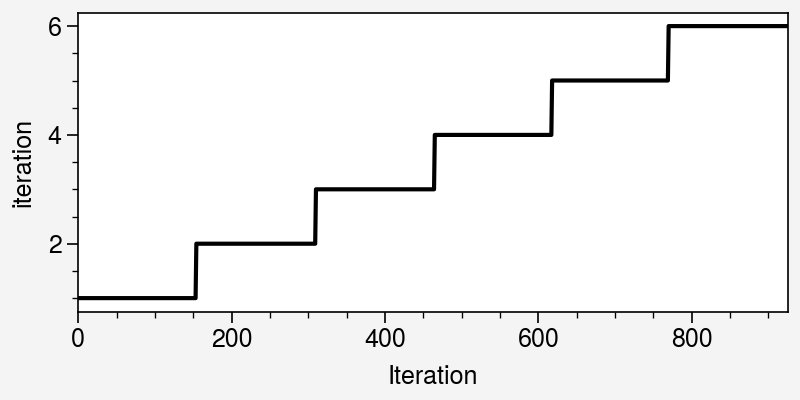

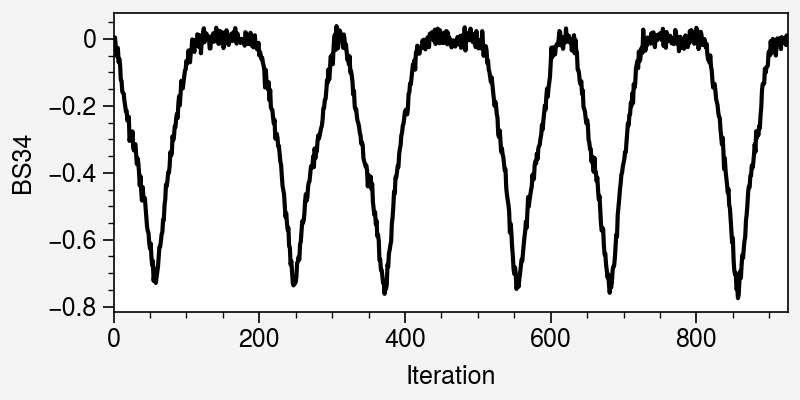

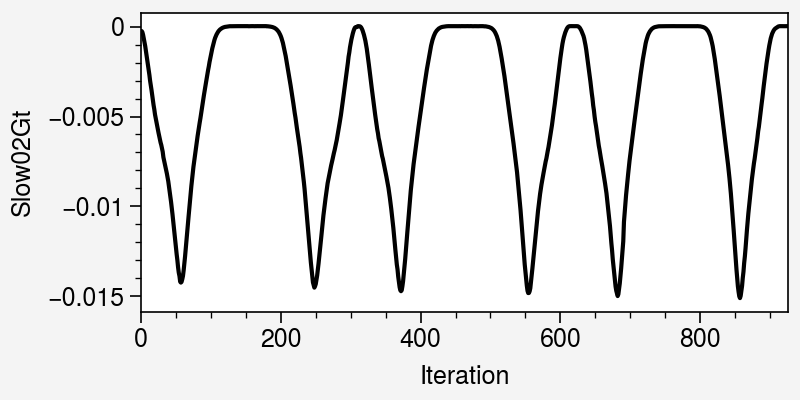

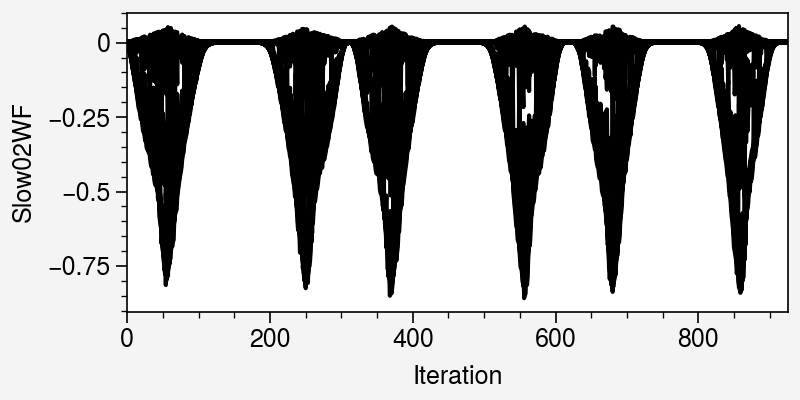

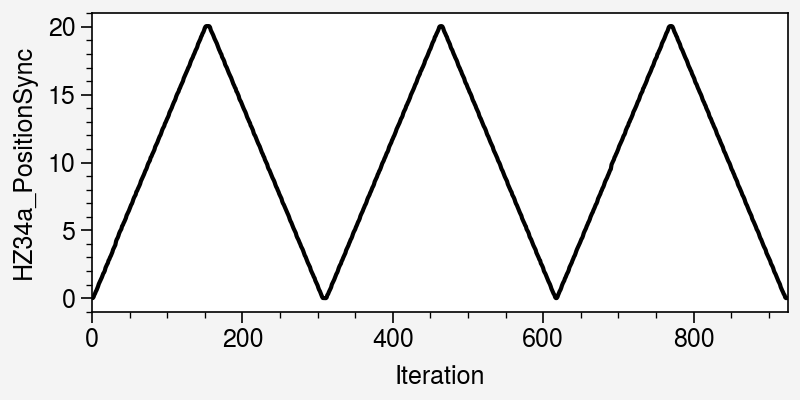

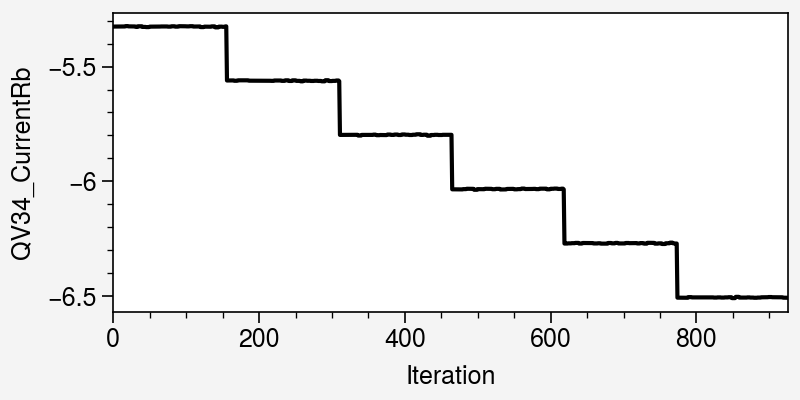

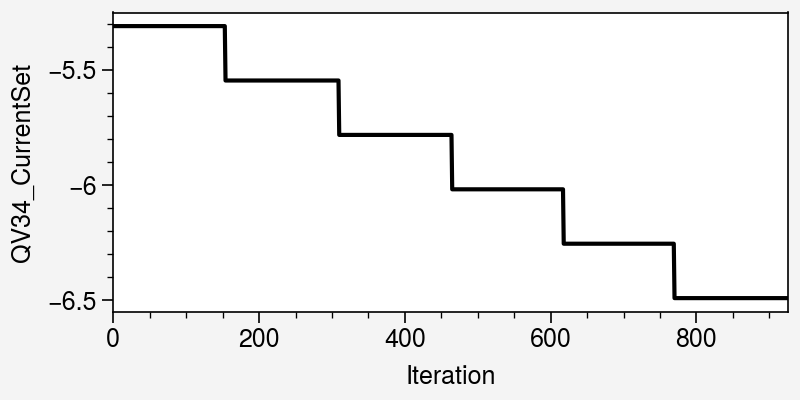

In [7]:
for name in data.dtype.names:
    if name == 'timestamp':
        continue
    fig, ax = pplt.subplots(figsize=(4, 2))
    ax.plot(data[name], color='black')
    ax.format(xlabel='Iteration', ylabel=name)
    plt.show()

In [8]:
# Get the quad id that is being scanned.
quad_id = get_quad_id(filename)

# Cut off the first few points.
_data = data[2:]

quad_currents = np.array(list(Counter(_data[f'{quad_id}_CurrentSet'])))

In [9]:
def build_data_dict(data):
    n_iterations = max(data['iteration'])
    data_dict = {
        'xvals': [],
        'profiles': [],
        'means': [],
        'stds': [],
    }
    for i in range(1, n_iterations + 1):
        slow = np.abs(_data['Slow02Gt'])
        idx = np.argwhere(_data['iteration'] == i)
        profile = slow[idx][:, 0]
        xx = _data[slits[0]][idx][:, 0]
        if i % 2 == 0:
            # The scanner is moving in the opposite direction.
            profile = np.flip(profile)
            xx = np.flip(xx)
        data_dict['profiles'].append(profile)
        data_dict['xvals'].append(xx)
    
    # Make all arrays the same length (they vary by 1 or 2)
    min_steps = min([len(profile) for profile in data_dict['profiles']])
    for key in data_dict.keys():
        data_dict[key] = [item[:min_steps] for item in data_dict[key]]

    # Estimate mean and std from profiles
    for i in range(n_iterations):
        xx = data_dict['xvals'][i]
        fx = data_dict['profiles'][i]
        N = np.sum(fx)
        mean = np.sum(fx * xx) / N
        std = np.sum(fx * (xx - mean)**2) / N
        data_dict['means'].append(mean)
        data_dict['stds'].append(std)    
        
    for key in data_dict.keys():
        data_dict[key] = np.array(data_dict[key])
        
    return data_dict, n_iterations

In [10]:
data_dict, n_iterations = build_data_dict(_data)

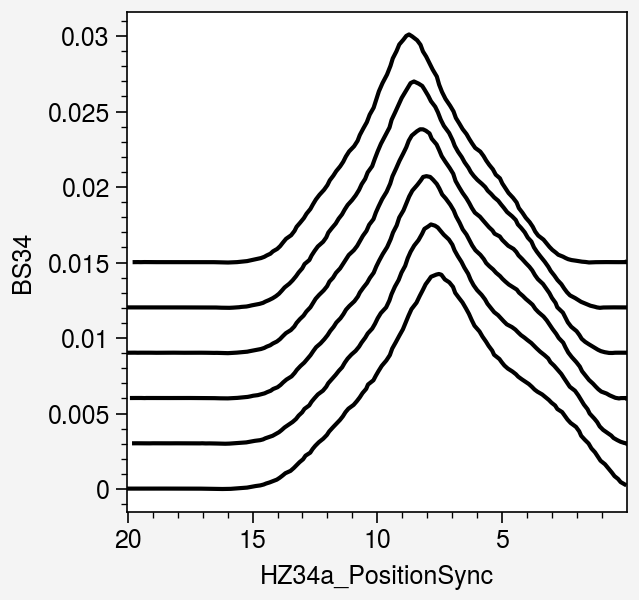

In [11]:
fig, ax = pplt.subplots()
for i in range(n_iterations):
    offset = i * 0.003
    ax.plot(
        data_dict['xvals'][i], 
        data_dict['profiles'][i] + offset, 
        color='black'
    )
ax.format(xlabel=slits[0], ylabel='BS34');

In [12]:
def plot_linear_fit(xdata, ydata, ax=None):
    
    def linear_fit(x, slope, intercept):
        return slope * x + intercept
    
    popt, pcov = opt.curve_fit(linear_fit, xdata, ydata)
    slope, intercept = popt
    ax.plot(xdata, linear_fit(xdata, *popt), color='lightgrey', zorder=0)
    ax.scatter(xdata, ydata, color='black', s=14)
    return slope, intercept

Text(0.03, 0.97, 'slope = 2.227')

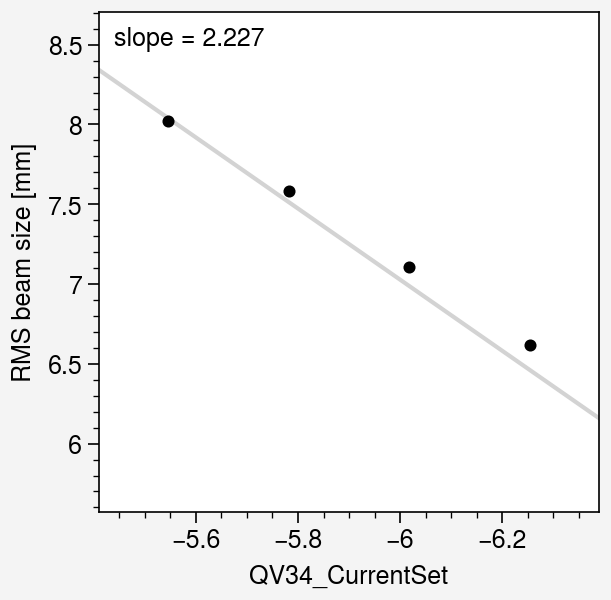

In [13]:
fig, ax = pplt.subplots()
slope, intercept = plot_linear_fit(quad_currents, data_dict['stds'], ax=ax)
xmin, xmax = ax.get_xlim()
ax.format(
    xlabel=f'{quad_id}_CurrentSet', 
    ylabel='RMS beam size [mm]',
    xlim=(xmin - 0.1, xmax + 0.1)
)
ax.annotate(f'slope = {slope:.3f}', xy=(0.03, 0.97), xycoords='axes fraction', 
            horizontalalignment='left', verticalalignment='top')

In [14]:
data_dicts = []
for filename in filenames:
    file = h5py.File(join(folder, filename), 'r')
    data = file['scandata']
    _data = data[2:]
    quad_id = get_quad_id(filename)
    quad_currents = np.array(list(Counter(_data[f'{quad_id}_CurrentSet'])))
    print(quad_id, quad_currents)
    data_dict, n_iterations = build_data_dict(data)
    data_dict['quad_id'] = quad_id
    data_dict['quad_currents'] = quad_currents
    data_dicts.append(data_dict)

QV34 [-5.31  -5.546 -5.782 -6.018 -6.254 -6.49 ]
QH33 [4.86  5.076 5.292 5.508 5.724 5.94 ]
QH13 [5.49000034 5.73400036 5.97800037 6.22200039 6.4660004  6.71000042]
QV12 [-5.85 -6.11 -6.37 -6.63 -6.89 -7.15]
QH11 [6.3  6.58 6.86 7.14 7.42 7.7 ]
QV10 [-1.8  -1.88 -1.96 -2.04 -2.12 -2.2 ]
QV09 [-1.44000002 -1.50400002 -1.56800002 -1.63200002 -1.69600003 -1.76000003]
QH08 [3.34889996 3.49773996 3.64657996 3.79541996 3.94425995 4.09309995]
QV07 [-2.925 -3.055 -3.185 -3.315 -3.445 -3.575]
QV06 [0.]
QH05 [0.]
QV04 [-3.30300007 -3.44980007 -3.59660007 -3.74340008 -3.89020008 -4.03700008]
QH03 [5.98500009 6.25100009 6.51700009 6.7830001  7.0490001  7.3150001 ]


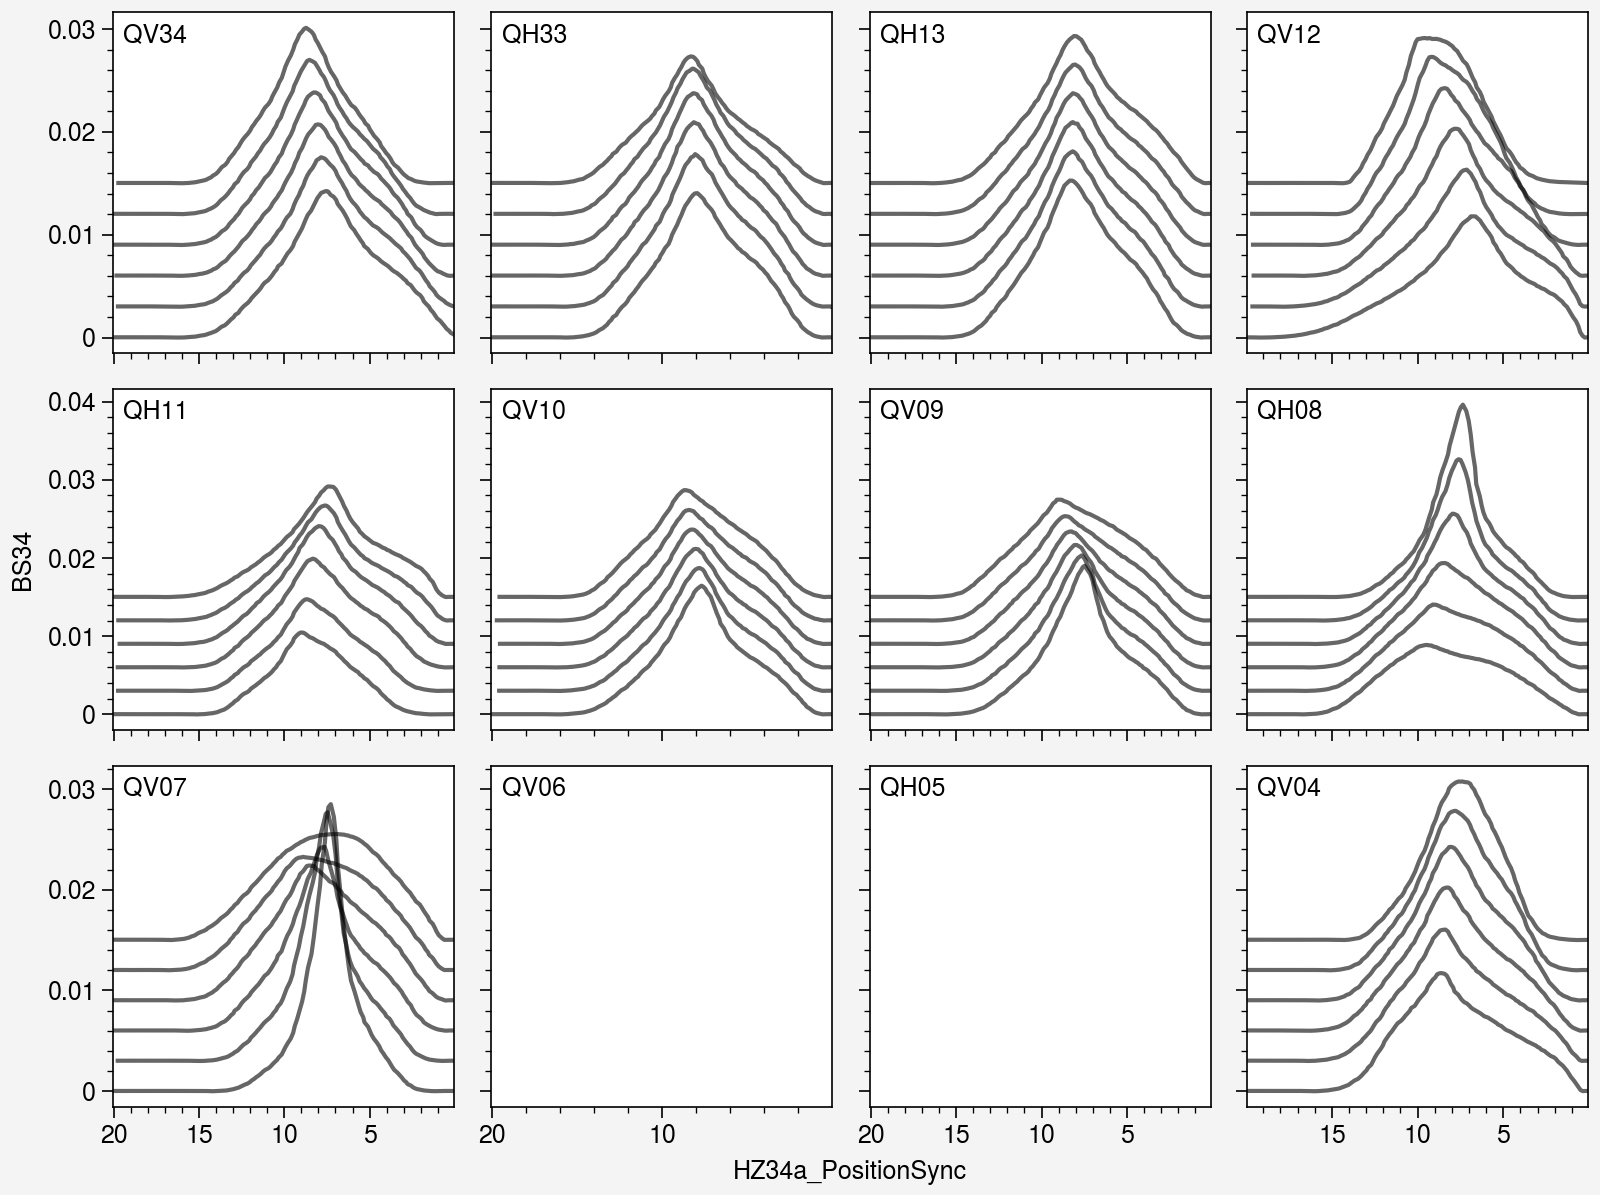

In [15]:
fig, axes = pplt.subplots(nrows=3, ncols=4, figwidth=8.0)
axes.format(xlabel=slits[0], ylabel='BS34')
for ax, data_dict in zip(axes, data_dicts):
    ax.annotate(data_dict['quad_id'], xy=(0.03, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')   
    if data_dict['quad_id'] in ['QV06', 'QH05']:
        continue
    for i in range(n_iterations):
        offset = i * 0.003
        ax.plot(
            data_dict['xvals'][i], 
            data_dict['profiles'][i] + offset, 
            color='black', alpha=0.6,
        )
        xmin, xmax = ax.get_xlim()
        if xmax > xmin:
            ax.set_xlim(xmax, xmin)
plt.savefig('_output/profiles')

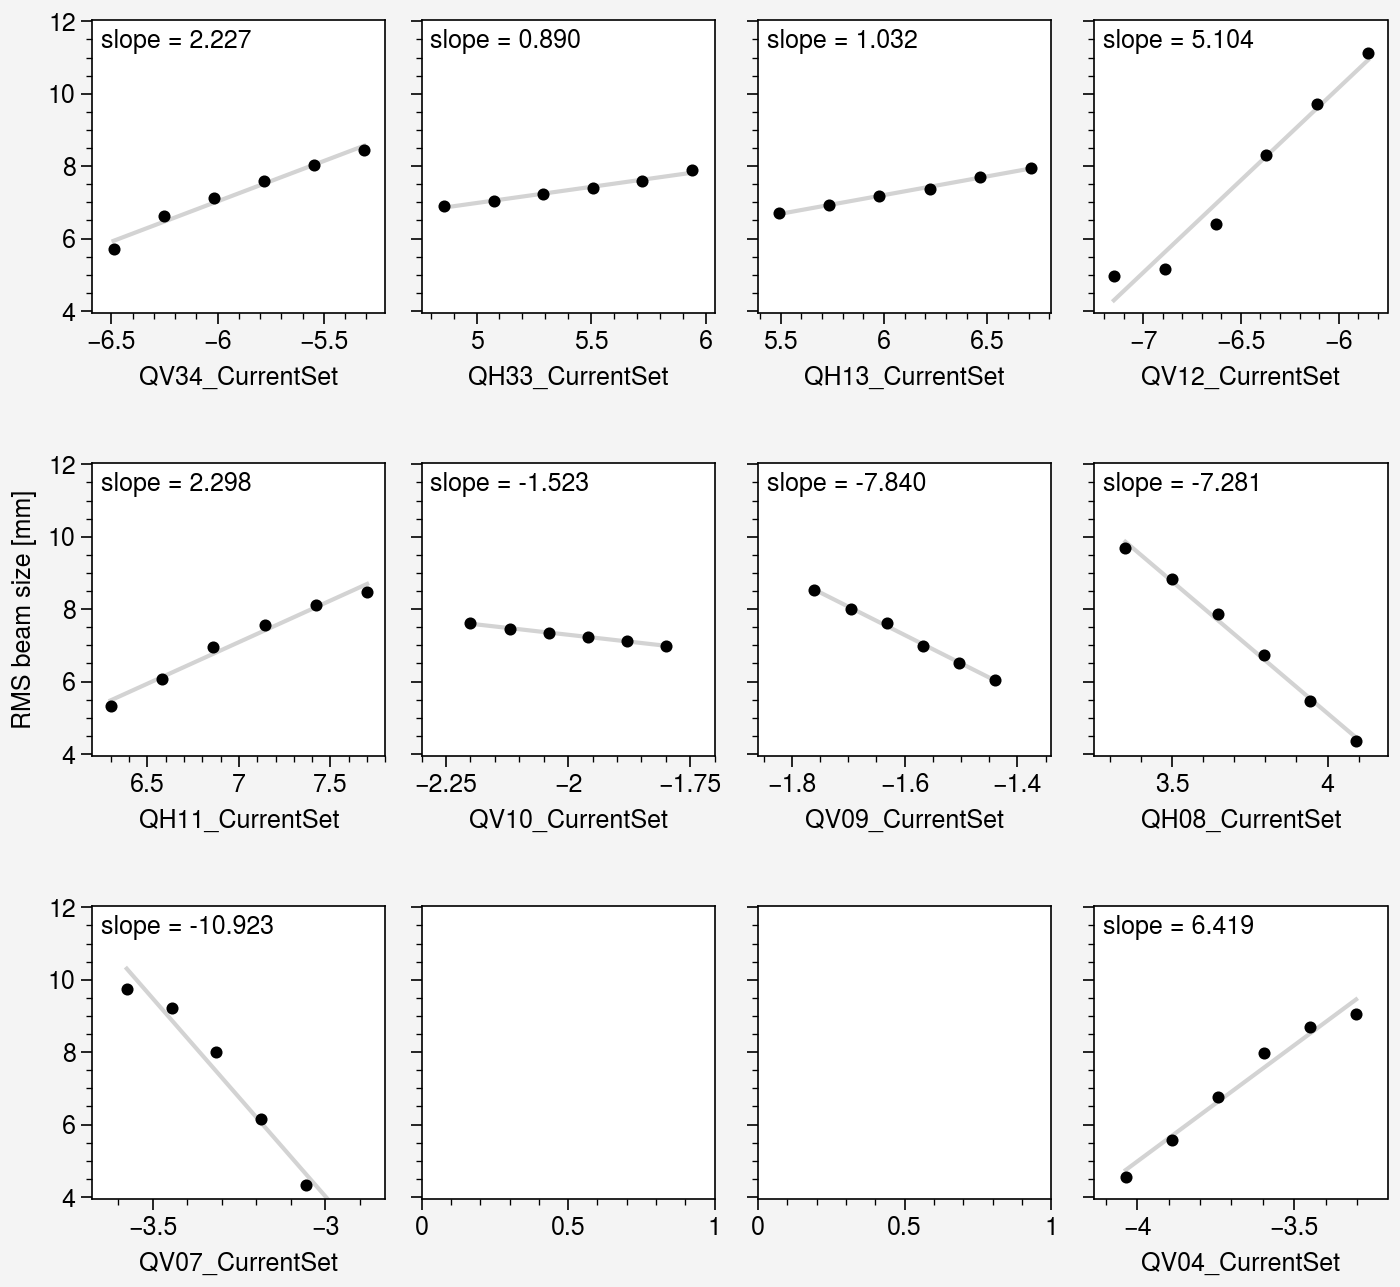

In [38]:
fig, axes = pplt.subplots(nrows=3, ncols=4, figwidth=7.0, sharex=False, sharey=True, hspace=6.0)
for i, (ax, data_dict) in enumerate(zip(axes, data_dicts)):
    if data_dict['quad_id'] in ['QV06', 'QH05']:
        continue    
    ax.format(xlabel=f"{data_dict['quad_id']}_CurrentSet")
    slope, intercept = plot_linear_fit(data_dict['quad_currents'], data_dict['stds'], ax=ax)
    ax.annotate(f'slope = {slope:.3f}', xy=(0.03, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    xmin, xmax = ax.get_xlim()
    xpad = 0.1
    if xmin > xmax:
        xmin, xmax = xmax, xmin
    ax.format(xlim=(xmin - xpad, xmax + xpad))

ymin, ymax = axes[0].get_ylim()
axes.format(ylim=(ymin, ymax * 1.05), ylabel='RMS beam size [mm]')
plt.savefig('_output/beam_size_vs_quad_current')

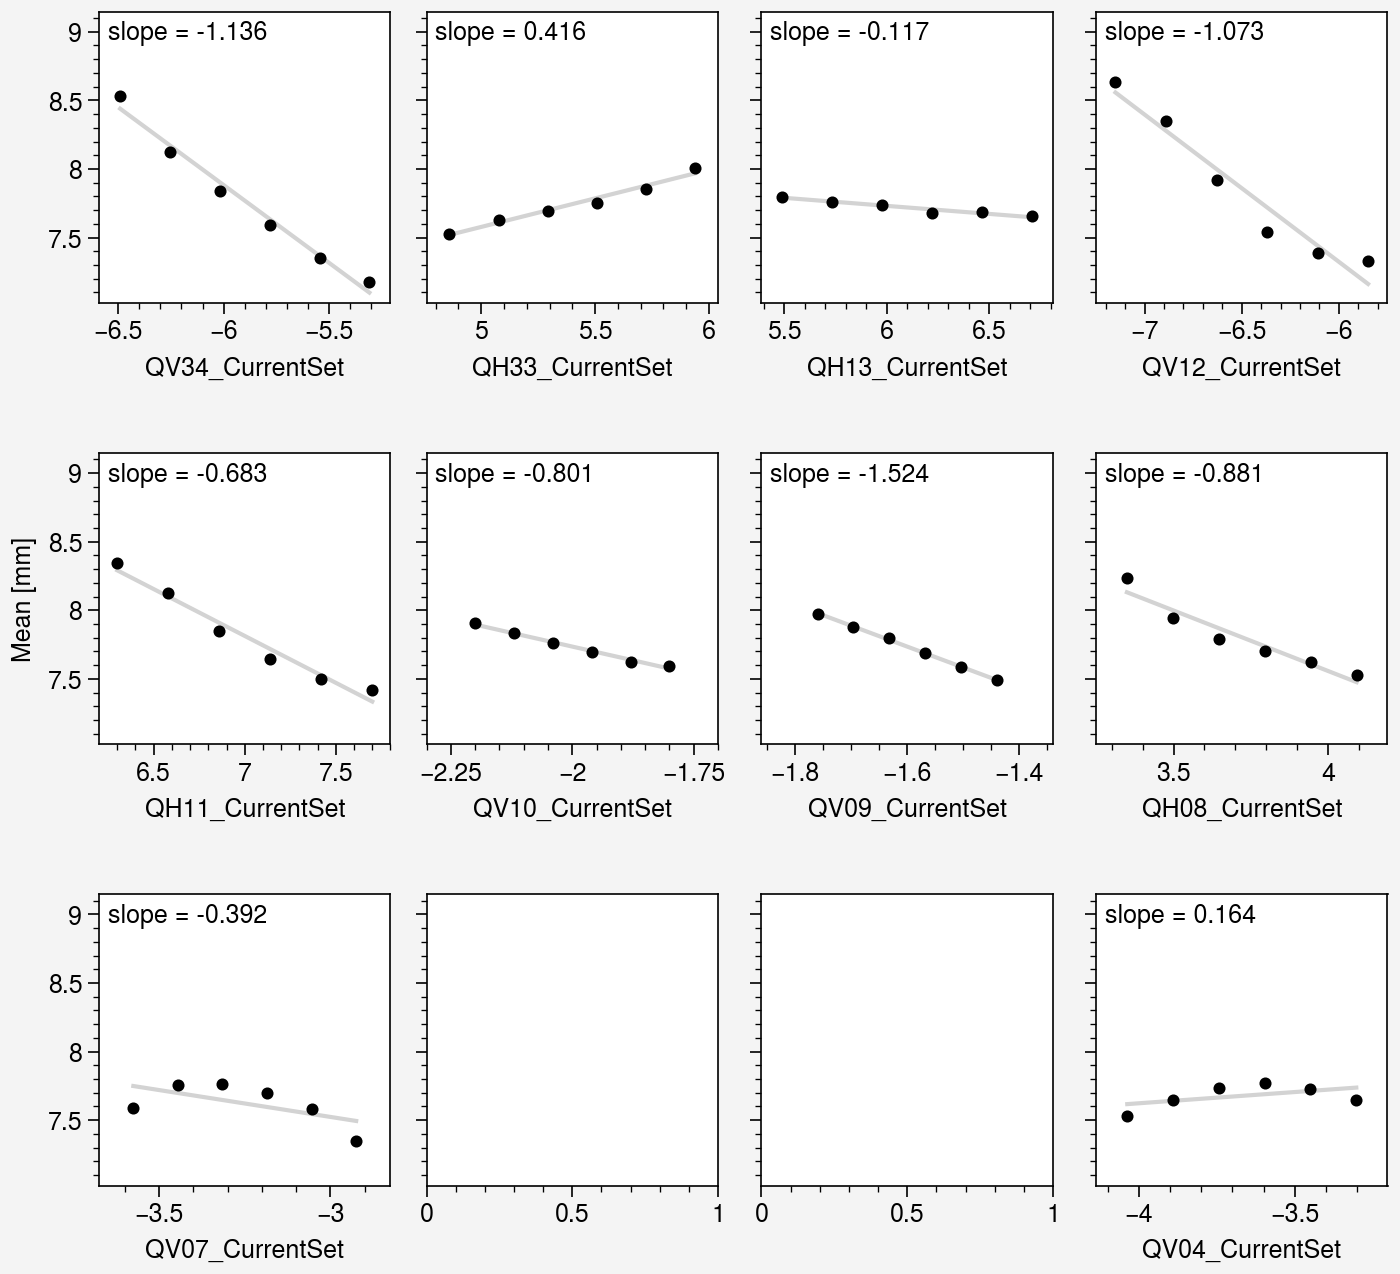

In [37]:
fig, axes = pplt.subplots(nrows=3, ncols=4, figwidth=7.0, sharex=False, sharey=True, hspace=6.0)
for i, (ax, data_dict) in enumerate(zip(axes, data_dicts)):
    if data_dict['quad_id'] in ['QV06', 'QH05']:
        continue    
    ax.format(xlabel=f"{data_dict['quad_id']}_CurrentSet")
    slope, intercept = plot_linear_fit(data_dict['quad_currents'], data_dict['means'], ax=ax)
    ax.annotate(f'slope = {slope:.3f}', xy=(0.03, 0.97), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top')
    xmin, xmax = ax.get_xlim()
    xpad = 0.1
    if xmin > xmax:
        xmin, xmax = xmax, xmin
    ax.format(xlim=(xmin - xpad, xmax + xpad))

ymin, ymax = axes[0].get_ylim()
axes.format(ylim=(ymin, ymax * 1.05), ylabel='Mean [mm]')
plt.savefig('_output/beam_mean_pos_vs_quad_current')